## 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

## 2. Tool 정의

`(1) 사용자 정의 - @tool decorator`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

#embeddings_model = OllamaEmbeddings(model="qwen2.5:1.5b") 
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "./db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """레스토랑 메뉴에서 정보를 검색합니다."""
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

`(2) LangChain 내장 도구`
- 일반 웹 검색을 위한 Tavily 초기화

In [4]:
from langchain_community.tools import TavilySearchResults


# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

### 2-1. bind_tools() 함수로 LLM과 Tool 연결하기

In [5]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]
print(type(search_menu))

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
print(type(llm_with_tools))

gpt-4o-mini
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.runnables.base.RunnableBinding'>


In [6]:
from langchain_core.messages import HumanMessage

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"스테이크"}',
                              'name': 'search_menu'},
                 'id': 'call_Go7m1TGNwTjlIivNolKmlldo',
                 'index': 0,
                 'type': 'function'}]}


In [7]:
# 도구 호출 ( Tavily )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"LangGraph는 무엇인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"LangGraph"}',
                              'name': 'search_web'},
                 'id': 'call_4AAAsR5YeTxBVxOf1pNzpQxm',
                 'index': 0,
                 'type': 'function'}]}


In [8]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"3+3은 얼마인가요?")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{}


In [9]:
pprint(tool_call)

AIMessage(content='3 + 3은 6입니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--f74ee9d4-f24d-4ada-a52a-39d23f04073c-0')


### 2-2. 도구 노드(ToolNode) 
- AI 모델이 요청한 도구(tool) 호출을 실행하는 역할을 처리하는 LangGraph 콤포넌트
- 작동 방식:
    - 가장 최근의 AIMessage에서 도구 호출 요청을 추출 (반드시, AIMessage는 반드시 tool_calls가 채워져 있어야 함)
    - 요청된 도구들을 병렬로 실행
    - 각 도구 호출에 대해 ToolMessage를 생성하여 반환

`(1) 도구 노드(Tool Node) 정의`



In [10]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의 
tools = [search_menu, search_web]
tool_node = ToolNode(tools=tools)

In [11]:
# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])

pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query":"스테이크"}',
                              'name': 'search_menu'},
                 'id': 'call_yM7RKPTqCHmrVK2B2lQYoweU',
                 'index': 0,
                 'type': 'function'}]}


`(2) 도구 노드(Tool Node) 실행`


In [12]:
# 도구 호출 결과를 메시지로 추가하여 실행 
# 도구 호출 
#tool_call_result = llm_with_tools.invoke([HumanMessage(content=f"스테이크 메뉴의 가격은 얼마인가요?")])
tool_call_result = llm_with_tools.invoke("스테이크 메뉴의 가격은 얼마인가요?")
results = tool_node.invoke({"messages": [tool_call_result]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print('**** --------------------------- ****')

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
9. 치킨 콘피
   • 가격: ₩23,000
   • 주요 식재료: 닭다리살, 허브, 마늘, 올리브 오일
   • 설명: 닭다리살을 허브와 마늘을 넣은 올리브 오일에 저온에서 장시간 조리한 프랑스 요리입니다. 부드럽고 촉촉한 육질이 특징이며, 로즈메리 감자와 제철 채소를 곁들여 제공합니다. 레몬 제스트를 뿌려 상큼한 향을 더했습니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
7. 랍스터 비스크
   • 가격: ₩28,000
   • 주요 식재료: 랍스터, 생크림, 브랜디, 파프리카
   • 설명: 랍스터 껍질과 육수로 오랜 시간 우려낸 진한 비스크 수프입니다. 생크림으로 부드러운 질감을 더하고 브랜디로 깊은 풍미를 살렸습

In [14]:
# LLM 모델을 이용하여 도구를 호출하여 실행 
results = tool_node.invoke({"messages": [llm_with_tools.invoke("LangGraph는 무엇인가요?")]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print()

<Document href="https://www.ibm.com/think/topics/langgraph"/>
LangGraph, created by [LangChain](https://www.ibm.com/think/topics/langchain), is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize [large language models](https://www.ibm.com/think/topics/large-language-models) (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the [...] By using a graph-based architecture, LangGraph enables users to scale artificial intelligence workflows without slowing down or sacrificing efficiency. LangGraph uses enhanced decision-making by modeling complex relationships between nodes, which means it uses AI agents to analyze their past actions and feedback. In the world of LLMs, this process is referred to as reflection. [...] **Agent systems**: LangGraph provides a framework for

## 3. ReAct Agent
- ReAct(Reasoning and Acting) : 가장 일반적인 에이전트
- 동작 방식:
    - 행동 (act): 모델이 특정 도구를 호출
    - 관찰 (observe): 도구의 출력을 모델에 다시 전달
    - 추론 (reason): 모델이 도구 출력을 바탕으로 다음 행동을 결정 (예: 또 다른 도구를 호출하거나 직접 응답을 생성)

- 논문: https://arxiv.org/abs/2210.03629

### create_react_agent() 쉽게 이해하기
* 1. 에이전트의 두뇌 역할
    * llm(언어모델)이 "생각"을 담당
    * 예시: "날씨 정보가 필요하니 날씨 API를 사용해야겠다"
* 2. 도구 사용 자동화
    * tools 리스트에 등록된 기능들을 필요시 자동 호출
    * 예시: 날씨 API 호출 → 결과 받아옴
* 3. 자체 점검 과정
    * 한 번에 해결되지 않으면 반복 실행
    * 예시:
        * 1차: "위치가 필요하니 위치 API 먼저 호출"
        * 2차: "받은 위치로 날씨 조회"
* 4. 최종 응답 생성
    * 모든 과정 종료 후 사용자에게 친절한 답변 구성
    * 예시: "오늘 서울은 맑고 25도입니다"

`(1) 랭그래프 내장 ReAct 에이전트 사용`

<class 'langgraph.graph.state.CompiledStateGraph'>


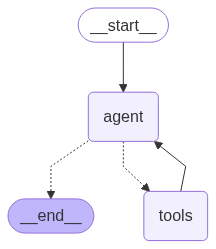

In [15]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent  # 미리 정의된 에이전트 생성 함수

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm, 
    tools=tools, 
)

"""
[create_react_agent() 설명]
1. 역할: 
   - 'ReAct(Reasoning + Acting)' 프레임워크 기반의 자동화 에이전트 생성
   - 에이전트가 '생각(Reasoning)'과 '행동(Acting)'을 반복하며 문제 해결

2. 동작 방식:
   - 사용자 질문 → LLM이 '생각' → 필요한 도구 선택 → 도구 실행 → 결과 분석 → 최종 응답
   - 이 과정을 자동으로 반복하는 그래프 구조 생성

3. 예시 시나리오:
   "오늘 서울 날씨 알려줘" 질문 시:
   1. 날씨 API 도구 사용 필요 판단
   2. 날씨 API 호출
   3. 결과 해석 후 사용자 응답 생성
"""

print(type(graph)) # <class 'langgraph.graph.StateGraph'>

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

```python
state = {
    "messages": [
        HumanMessage(...),  # 입력
        AIMessage(...),     # 도구 사용 요청
        ToolMessage(...),   # 도구 실행 결과
        AIMessage(...)      # 최종 답변
    ]
}
```    
* 다중 메시지 타입 지원
    * HumanMessage: 사용자 입력
    * AIMessage: AI의 응답/생각
    * ToolMessage: 도구 실행 결과
    * SystemMessage: 시스템 지시
```python
# 이전 대화 포함 예제
inputs = {
    "messages": [
        HumanMessage("스테이크 추천해줘"),
        AIMessage("안심 스테이크가 인기 메뉴입니다"),
        HumanMessage("가격은 얼마인가요?")  # 이전 맥락 유지
    ]
}
```


In [16]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}

"""
[실행 과정]
1. inputs → 그래프 시작 노드로 전달
2. 각 노드에서 'messages' 리스트 업데이트
3. 최종 상태 반환 (모든 메시지 포함)
"""
messages = graph.invoke(inputs)

for m in messages['messages']:
    print(type(m), m)
    m.pretty_print()

<class 'langchain_core.messages.human.HumanMessage'> content='스테이크 메뉴의 가격은 얼마인가요?' additional_kwargs={} response_metadata={} id='6b7b038d-e029-46cb-8c7a-a6ac594bb82e'
================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_7hmkc1AyemnQLnxaHxovSzKt', 'function': {'arguments': '{"query":"스테이크"}', 'name': 'search_menu'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--3bded04b-3435-4a78-96ab-fd3f3dac80bd-0' tool_calls=[{'name': 'search_menu', 'args': {'query': '스테이크'}, 'id': 'call_7hmkc1AyemnQLnxaHxovSzKt', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_7hmkc1AyemnQLnxaHxovSzKt)
 Call ID: call_7hmkc1AyemnQ

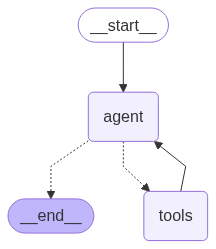

In [17]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from textwrap import dedent  # 들여쓰기 자동 조정

# 시스템 프롬프트
# system_prompt = dedent("""
# You are an AI assistant designed to answer human questions. 
# You can use the provided tools to help generate your responses.

# Follow these steps to answer questions:
#     1. Carefully read and understand the question.
#     2. Use the provided tools to obtain necessary information.
#     3. Immediately after using a tool, cite the source using the format below.
#     4. Construct an accurate and helpful answer using the tool outputs and citations.
#     5. Provide the final answer when you determine it's complete.

# When using tools, follow this format:
#     Action: tool_name
#     Action Input: input for the tool

# Immediately after receiving tool output, cite the source as follows:
#     [Source: tool_name | document_title/item_name | url/file_path]

# For example:
#     Action: search_menu
#     Action Input: 스테이크
    
#     (After receiving tool output)
#     [Source: search_menu | 스테이크 | ./data/data.txt]
#     스테이크에 대한 정보는 다음과 같습니다...

#     Action: search_web
#     Action Input: History of AI

#     (After receiving tool output)
#     [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
#     AI의 역사는 다음과 같이 요약됩니다...

# If tool use is not necessary, answer directly.

# Your final answer should be clear, concise, and directly related to the user's question. 
# Ensure that every piece of factual information in your response is accompanied by a citation.

# Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
# Do not provide any information without a corresponding citation.
# """)

# 시스템 프롬프트 (한글 버전)
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 스테이크 | ./data/menu.txt]  
스테이크 정보: 양념 스테이크 35,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm,        # 언어 모델 (예: ChatOpenAI 인스턴스)
    tools=tools,   # 사용 가능한 도구 리스트
    #state_modifier=system_prompt,
    #system_message=SystemMessage(content=system_prompt),
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),   # 시스템 프롬프트 설정 (AI의 행동 지침)
        HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")  # 사용자 질문
    ]
#inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
#messages = graph.invoke(inputs)

# 그래프 실행 (SystemMessage 포함)
messages = graph.invoke({"messages": messages})
"""
[실행 과정]
1. SystemMessage를 먼저 처리 → AI의 행동 규칙 설정
2. HumanMessage 처리 → 질문 분석 및 도구 사용 결정
3. 필요한 경우 tools 리스트의 도구들 자동 호출
4. 최종 응답 생성
"""

for m in messages['messages']:
    m.pretty_print()
    
"""
    [출력 예시]
    System: (시스템 프롬프트 내용 요약)...
    Human: 스테이크 메뉴의 가격은 얼마인가요?
    AI: [출처: menu_db | 스테이크 | ./db/menu.csv] 
        스테이크 메뉴는 35,000원입니다.
    """    

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 스테이크 | ./data/menu.txt]  
스테이크 정보: 양념 스테이크 35,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  sear

'\n    [출력 예시]\n    System: (시스템 프롬프트 내용 요약)...\n    Human: 스테이크 메뉴의 가격은 얼마인가요?\n    AI: [출처: menu_db | 스테이크 | ./db/menu.csv] \n        스테이크 메뉴는 35,000원입니다.\n    '

`(2) 조건부 엣지 함수를 사용자 정의`
- `should_continue` 함수에서 도구 호출 여부에 따라 종료 여부를 결정
- 도구 실행이 필요한 경우에는 그래프가 종료되지 않고 계속 실행 

<class 'langgraph.graph.state.CompiledStateGraph'>


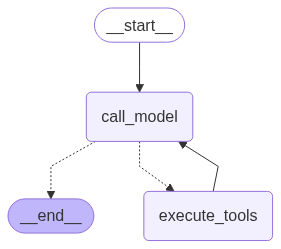

In [19]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_9v9ALHEQKvuqqx2hqflnA2rX)
 Call ID: call_9v9ALHEQKvuqqx2hqflnA2rX
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_me

`(3) tools_condition 활용`
- LangGraph에서 제공하는 도구 사용을 위한 조건부 엣지 함수
- 최신 메시지(결과)가 도구 호출이면 -> `tools_condition`이 도구로 라우팅
- 최신 메시지(결과)가 도구 호출이 아니면 -> `tools_condition`이 `END`로 라우팅

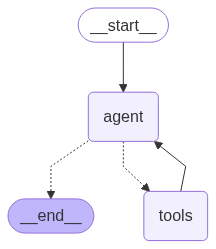

In [21]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="해산물 파스타의 가격은 얼마인가요? 해산물 파스타에 어울리는 음료는 무엇인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

해산물 파스타의 가격은 얼마인가요? 해산물 파스타에 어울리는 음료는 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_7MTNLUxPTx4Nb6zcQBNKyP0H)
 Call ID: call_7MTNLUxPTx4Nb6zcQBNKyP0H
  Args:
    query: 해산물 파스타
  search_menu (call_ylAq1uQw60Amcgn2Ek0rvuCm)
 Call ID: call_ylAq1uQw60Amcgn2Ek0rvuCm
  Args:
    query: 음료
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
6. 해산물 파스타
   • 가격: ₩24,000
   • 주요 식재료: 링귀네 파스타, 새우, 홍합, 오징어, 토마토 소스
   • 설명: 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다. 토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다. 파슬리를 뿌려 향긋한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
10. 티라미수
    • 가격: ₩9,000
    • 주요 식재료: 마스카포네 치즈, 에스프레소, 카카오 파우더, 레이디핑거 비스킷
    • 설명: 부드러운 마스카포네 치즈 크림과 에스프레소에 적신 레이디핑거 비스킷을 층층이 쌓아 만든 이탈리아 정통 디저트입니다. 

## 4. MemorySaver

1. 상태의 일시성 문제:
   - 기본적으로 그래프 실행 시 상태는 일시적 (stateless)
   - 그래프를 재실행하는 경우 상태가 초기화되는 문제가 있음 
   - 따라서, 중단이 있는 다중 턴 대화가 어려움 

2. MemorySaver 기능:
   - 가장 쉽게 사용할 수 있는 체크포인터 (각 단계 후 그래프 상태를 자동으로 저장)
   - 그래프 상태를 위한 인메모리 키-값 저장소
   - 지속성(persistence) 있는 메모리 기능을 제공하여 그래프 객체가 체크포인터부터 이어서 실행 가능 

3. 메모리의 필요성:
   - 대화의 연속성: 여러 턴에 걸친 대화를 유지 
   - 중단 허용: 대화 중 중단이 있어도 이전 상태를 복원
   - 유연한 상태 관리: 다양한 대화 스레드를 독립적으로 관리

### 4-1. 사용자 정의 그래프

In [46]:
# 그래프 실행 - 이전 대화 내용을 기억하는지 못하는 문제가 있음 
inputs = {"messages": [HumanMessage(content="이 중에 하나만 추천해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

이 중에 하나만 추천해주세요.
================================== Ai Message ==================================

어떤 것 중에서 추천해드릴까요? 더 구체적인 정보를 주시면 도움이 될 것 같습니다.


`(1) 체크포인터 지정`
- 그래프를 컴파일할 때 체크포인터를 지정

In [23]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 기반 체크포인트 저장소 초기화
memory = MemorySaver()
"""
[MemorySaver 설명]
1. 역할:
   - 그래프 실행 상태를 메모리(RAM)에 저장하는 체크포인트 시스템
   - 실행 중단/재개 시 상태 복원 가능

2. 특징:
   - 휘발성 저장소 (프로세스 종료 시 데이터 소멸)
   - 개발/테스트 환경에 적합 (간편한 사용)
   - 작은 규모의 상태 관리에 최적화

3. 저장 내용 예시:
   - 각 노드의 출력 결과
   - 메시지 기록
   - 사용자 정의 상태 데이터
"""

"""
[체크포인트 적용 효과]
1. 실행 상태 추적:
   - graph_memory.get_state()로 현재 상태 조회 가능
   - 예: 특정 노드 실패 시 실패 지점부터 재개

2. 주요 사용 사례:
   - 장시간 실행 작업의 중간 저장
   - 디버깅 시 특정 단계 상태 검사
   - 사용자 세션 관리 (예: 채팅 기록 유지)

3. 저장 메커니즘:
   - 각 노드 실행 후 자동 상태 저장
   - key 기반으로 상태 검색 (기본값: 세션 ID)
"""
graph_memory = builder.compile(checkpointer=memory)

"""
[MemorySaver vs 영구 저장소]
1. MemorySaver (메모리):
   - 장점: 설정 간편, 빠른 접근
   - 단점: 서버 재시작 시 데이터 손실

2. FileSaver/DB 저장소:
   - 장점: 영구 보존
   - 단점: 추가 설정 필요
"""

'\n[MemorySaver vs 영구 저장소]\n1. MemorySaver (메모리):\n   - 장점: 설정 간편, 빠른 접근\n   - 단점: 서버 재시작 시 데이터 손실\n\n2. FileSaver/DB 저장소:\n   - 장점: 영구 보존\n   - 단점: 추가 설정 필요\n'

`(2) 체크포인터 사용`
- 메모리 사용 시 `thread_id`를 지정 
- 체크포인터는 그래프의 각 단계에서 상태를 기록 (그래프 각 단계의 모든 상태를 컬렉션으로 저장)
- 나중에 `thread_id`를 사용하여 이 스레드에 접근 가능 

In [24]:
config = {
    "configurable": {"thread_id": "1"}  # 고유 세션 ID (사용자/채팅방 구분용)
}
"""
[config 설정 설명]
1. thread_id: 
   - 대화 세션을 구분하는 고유 키
   - 동일 ID로 실행 시 이전 상태 복원 가능
   - 예: 사용자별로 다른 ID 할당 ("user1", "user2")
"""

messages = [HumanMessage(content="스테이크 메뉴의 가격은 얼마인가요?")]
messages = graph_memory.invoke(
    {"messages": messages},     # 입력 데이터
    config                      # 체크포인트 설정
)
"""
[실행 과정]
1. thread_id "1"의 이전 상태 확인 (없으면 새 세션 시작)
2. 메시지 처리:
   - 시스템 프롬프트 자동 적용 (생략됨)
   - 도구 사용 필요 시 execute_tools 노드 호출
3. 실행 상태를 메모리에 저장 (MemorySaver)
4. 중간 실패 시 config로 재시작 가능
"""

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_M6Kbh1cAisHbwBVTrgLE0WRo)
 Call ID: call_M6Kbh1cAisHbwBVTrgLE0WRo
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_me

In [25]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="둘 중에 더 저렴한 메뉴는 무엇인가요?")]
messages = graph_memory.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

스테이크 메뉴의 가격은 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_M6Kbh1cAisHbwBVTrgLE0WRo)
 Call ID: call_M6Kbh1cAisHbwBVTrgLE0WRo
  Args:
    query: 스테이크
================================= Tool Message =================================
Name: search_menu

<Document source="./data/restaurant_menu.txt"/>
1. 시그니처 스테이크
   • 가격: ₩35,000
   • 주요 식재료: 최상급 한우 등심, 로즈메리 감자, 그릴드 아스파라거스
   • 설명: 셰프의 특제 시그니처 메뉴로, 21일간 건조 숙성한 최상급 한우 등심을 사용합니다. 미디엄 레어로 조리하여 육즙을 최대한 보존하며, 로즈메리 향의 감자와 아삭한 그릴드 아스파라거스가 곁들여집니다. 레드와인 소스와 함께 제공되어 풍부한 맛을 더합니다.
</Document>

---

<Document source="./data/restaurant_menu.txt"/>
8. 안심 스테이크 샐러드
   • 가격: ₩26,000
   • 주요 식재료: 소고기 안심, 루꼴라, 체리 토마토, 발사믹 글레이즈
   • 설명: 부드러운 안심 스테이크를 얇게 슬라이스하여 신선한 루꼴라 위에 올린 메인 요리 샐러드입니다. 체리 토마토와 파마산 치즈 플레이크로 풍미를 더하고, 발사믹 글레이즈로 마무리하여 고기의 풍미를 한층 끌어올렸습니다.
</Document>

---

<Document source="./data/restaurant_me

### 4-2. 내장 ReAct 

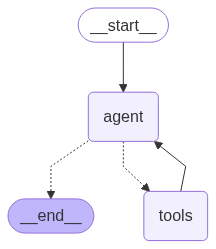

In [26]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langchain_core.messages import SystemMessage

# 메모리 초기화 
memory = MemorySaver()

# 그래프 생성 
graph = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=system_prompt,
    checkpointer=memory,
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
config = {"configurable": {"thread_id": "2"}}

#messages = [HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")]
messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="채식주의자를 위한 메뉴가 있나요?")
    ]

messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 스테이크 | ./data/menu.txt]  
스테이크 정보: 양념 스테이크 35,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  searc

In [28]:
config = {"configurable": {"thread_id": "2"}}
messages = [HumanMessage(content="방금 답변에 대한 출처가 있나요?")]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 스테이크  

(도구 실행 후)  
[출처: search_menu | 스테이크 | ./data/menu.txt]  
스테이크 정보: 양념 스테이크 35,000원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

채식주의자를 위한 메뉴가 있나요?
================================== Ai Message ==================================
Tool Calls:
  searc

## 5. Gradio 챗봇

In [ ]:
import gradio as gr
from typing import List, Tuple
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

# 메모리 사용 준비
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# 예시 질문들
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 답변 메시지 처리를 위한 함수
def process_message(message: str, history: List[Tuple[str, str]], thread_id: str) -> str:
    try:
        config = {"configurable": {"thread_id": thread_id}}
        inputs = {"messages": [HumanMessage(content=message)]}
        
        result = graph_memory.invoke(inputs, config=config)
        
        if "messages" in result:
            # 메시지 로깅 (선택사항)
            print(f"스레드 ID: {thread_id}")
            for msg in result["messages"]:
                msg.pretty_print()

            last_message = result["messages"][-1]
            if isinstance(last_message, AIMessage):
                return last_message.content

        return "응답을 생성하지 못했습니다."

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = process_message(message, history, self.thread_id)
        return response

chatbot = ChatBot()


# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다. 정보의 출처를 함께 제공합니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

In [30]:
# 데모 종료
demo.close()

Closing server running on port: 7860
